# Univariate

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,
                              seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
def split_data(data, test_split):
    l=len(data)
    t_idx =round(l*(1-test_split))
    train, test= data[:t_idx],data[t_idx:]
    print(f'train:{len(train)}, test:{len(test)}')
    return train,test

In [10]:
def check_stationarity(df):
    results =adfuller(df)[1:3]
    s= 'Non-staionary'
    if results[0]<0.05:
        s='Staionary'
    print(f"'{s}\t p-val :{results[0]}\t lags:{results[1]}")
    return (s, results[0])

In [24]:
def get_best_model(score, c='AIC'):
    initial_score=score[0][c]
    best_model=0
    for k,v in score.items():
        if v[c]<initial_score:
            initial_score=v[c]
            best_model=k
    print(f'Best model:{best_model} with lowest {c} score:{initial_score}')
    return score[best_model]['model']

In [5]:
def plot_forecast(model,start,train,test):
    forecast =pd.DataFrame(model.forecast(test.shape[0]),
                          index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train','orig_test','forecast'])
    plt.show()

In [6]:
def combinator(items):
    combo=[i for i in product(*items)]
    return combo

In [7]:
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')
life = pd.read_csv(life_file,
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)
milk = pd.read_csv(milk_file,
                   index_col='month',
                   parse_dates=True)

<AxesSubplot: title={'center': 'Monthly Milk Production'}, xlabel='month'>

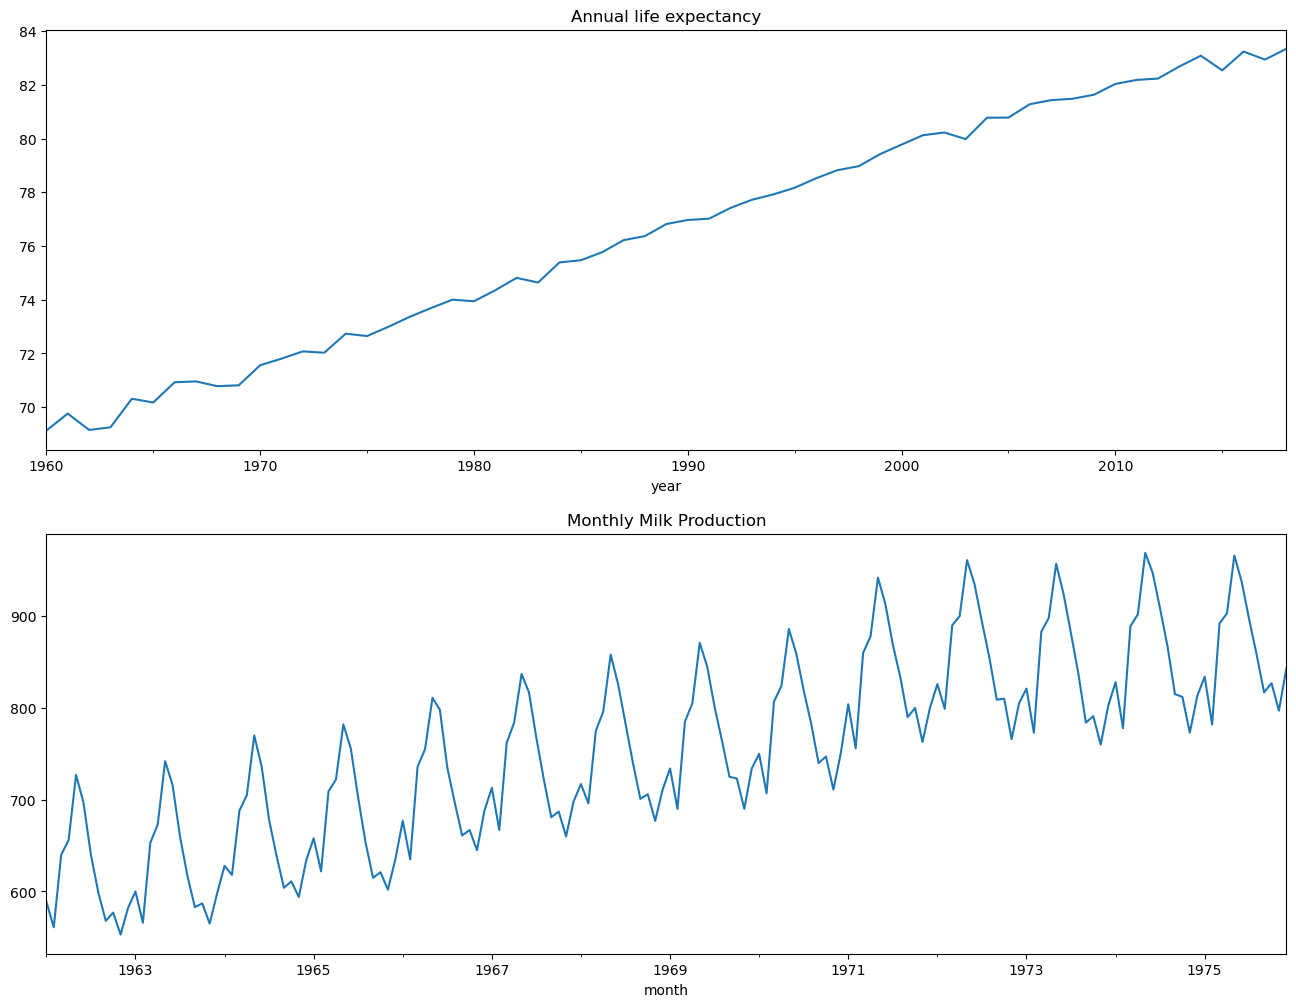

In [6]:
fig, ax =plt.subplots(2,1,figsize=(16,12))
life.plot(title='Annual life expectancy',
         legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production',
         legend=False,ax=ax[1])

In [16]:
test_split=0.15
milk_train, milk_test =split_data(milk, test_split)
life_train, life_test= split_data(life, test_split)

train:143, test:25
train:50, test:9


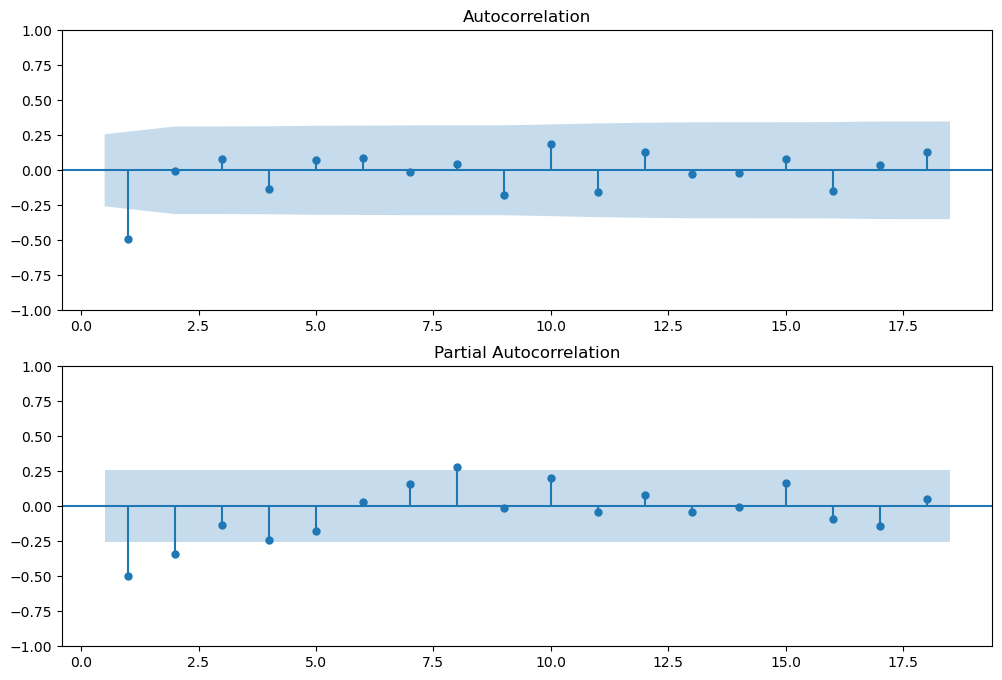

In [16]:
life_diff=life.diff().dropna()
fig, ax =plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff,zero=False,ax=ax[0])
plot_pacf(life_diff,zero=False,ax=ax[1])
plt.show()

In [8]:
milk_diff_12=milk.diff(12).dropna()

In [11]:
check_stationarity(milk_diff_12)

'Non-staionary	 p-val :0.1607988052771135	 lags:12


('Non-staionary', 0.1607988052771135)

In [12]:
milk_diff_12_1 =milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Staionary	 p-val :1.8654234318788342e-05	 lags:11


('Staionary', 1.8654234318788342e-05)

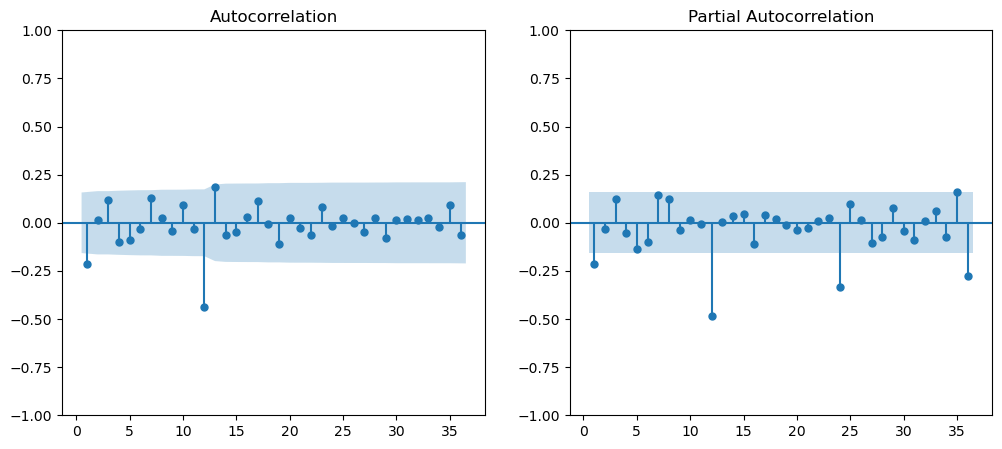

In [13]:
fig, ax =plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False,ax=ax[0],lags=36)
plot_pacf(milk_diff_12_1, zero=False,ax=ax[1],lags=36)
plt.show()

## Forecasting univariate

In [15]:
trend=['add','mul']
damped=[True,False]
life_ex_comb=combinator([trend,damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [18]:
train=life_train.values.ravel()
y=life_test.values.ravel()
score={}
for i, (t,dp) in enumerate(life_ex_comb):
    exp=ExponentialSmoothing(train,
                            trend=t,
                            damped_trend=dp,
                            seasonal=None)
    model= exp.fit(use_brute=True, optimized=True)
    y_hat =model.forecast(len(y))
    score[i]={
        'trend':t,
        'damped':dp,
        'AIC':model.aic,
        'BIV':model.bic,
        'AICc':model.aicc,
        'RMSPE':rmspe(y,y_hat),
        'RMSE':rmse(y,y_hat),
        'MAPE':mape(y,y_hat),
        'model':model
    }
    

In [25]:
life_best_model=get_best_model(score,'AIC')

Best model:1 with lowest AIC score:-137.03060179180176


In [26]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Fri, 13 Jan 2023"
Box-Cox:,False,Time:,00:23:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621954,alpha,True
smoothing_trend,0.1621954,beta,True


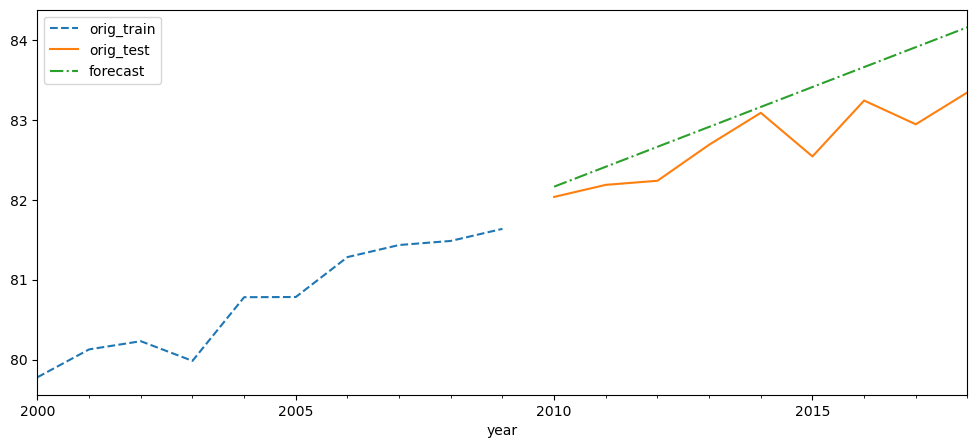

In [27]:
plot_forecast(life_best_model,'2000',life_train,life_test)

In [28]:
trend , damped= ['add', 'mul'], [True, False]
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal,
periods])

In [29]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train,
                        trend=t,
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic,
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [30]:
milk_model = get_best_model(milk_model_scores)

Best model:8 with lowest AIC score:593.7138857685106


In [31]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Fri, 13 Jan 2023"
Box-Cox:,False,Time:,00:27:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859108,alpha,True
smoothing_trend,0.000000,beta,True


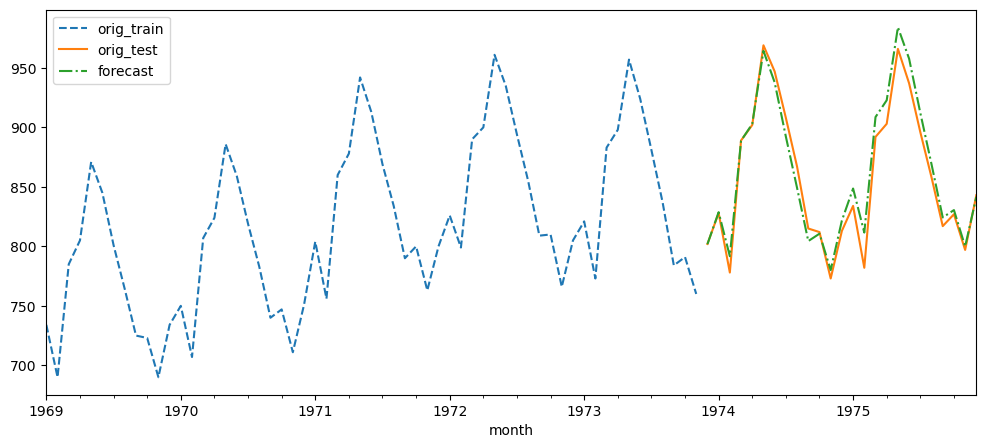

In [32]:
plot_forecast(milk_model, '1969',milk_train,milk_test)

## Forecast univariate Non-seasonal ARIMa

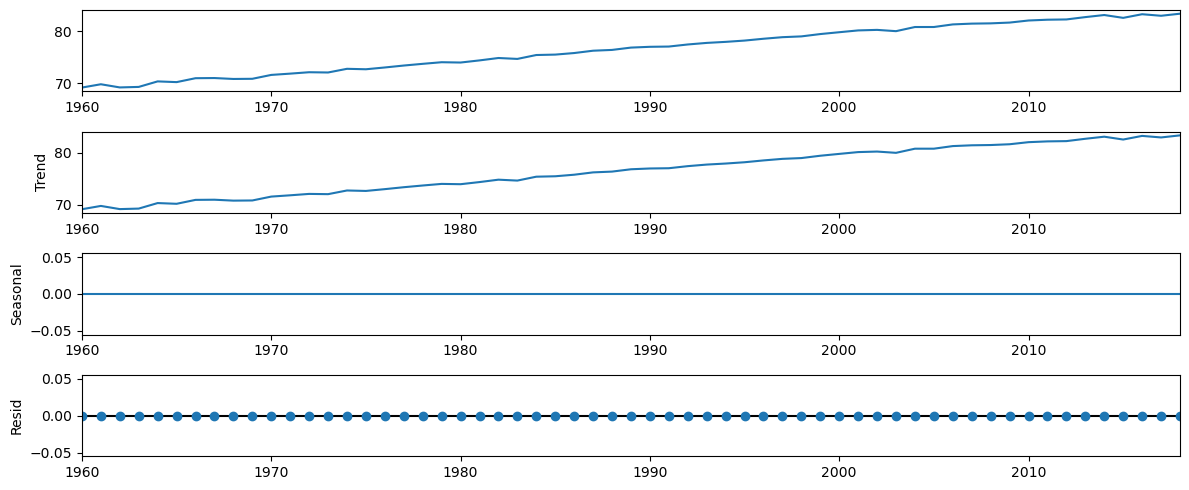

In [34]:
decomposed=seasonal_decompose(life)
decomposed.plot()
plt.show()

In [36]:
life_df1=life.diff().dropna()
check_stationarity(life_df1)

'Staionary	 p-val :1.556218967600307e-14	 lags:1


('Staionary', 1.556218967600307e-14)

<AxesSubplot: xlabel='year'>

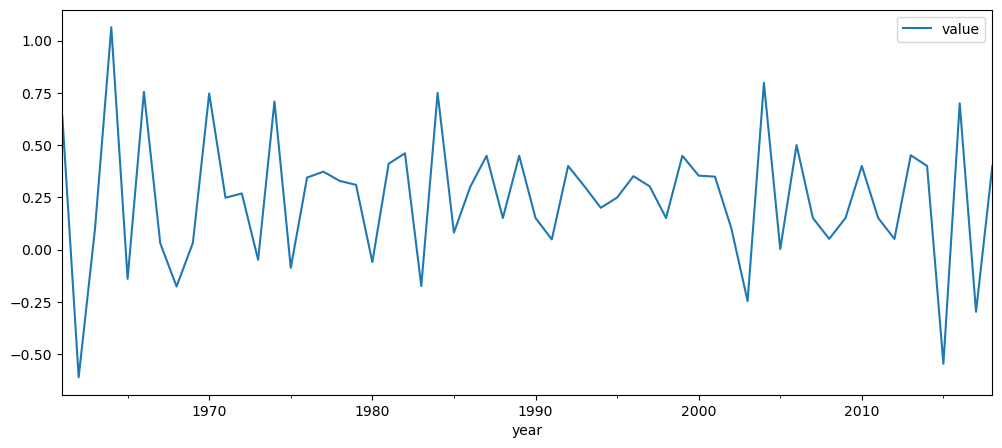

In [37]:
life_df1.plot()

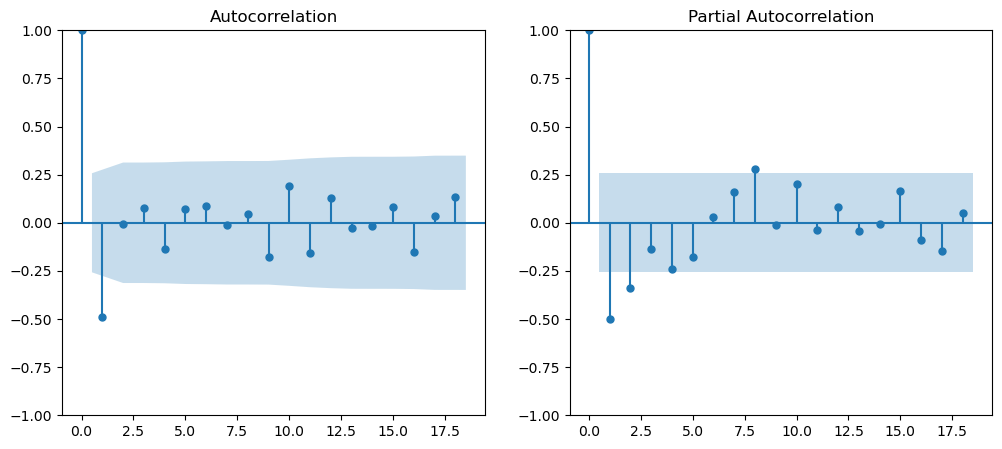

In [38]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]); plt.show()

In [39]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Fri, 13 Jan 2023   AIC                             52.321
Time:                        00:44:57   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
(acorr_ljungbox(results.resid,
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

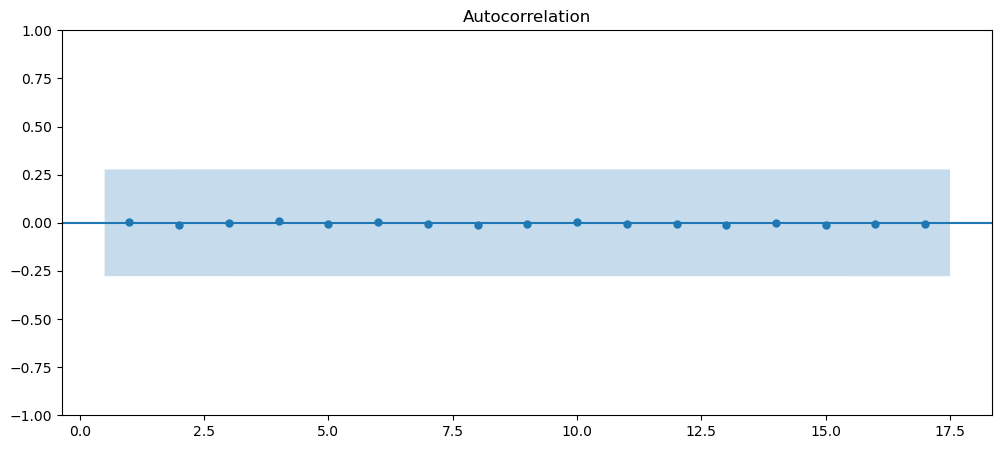

In [42]:
plot_acf(results.resid, zero=False);plt.show() #no correlation for the residuals

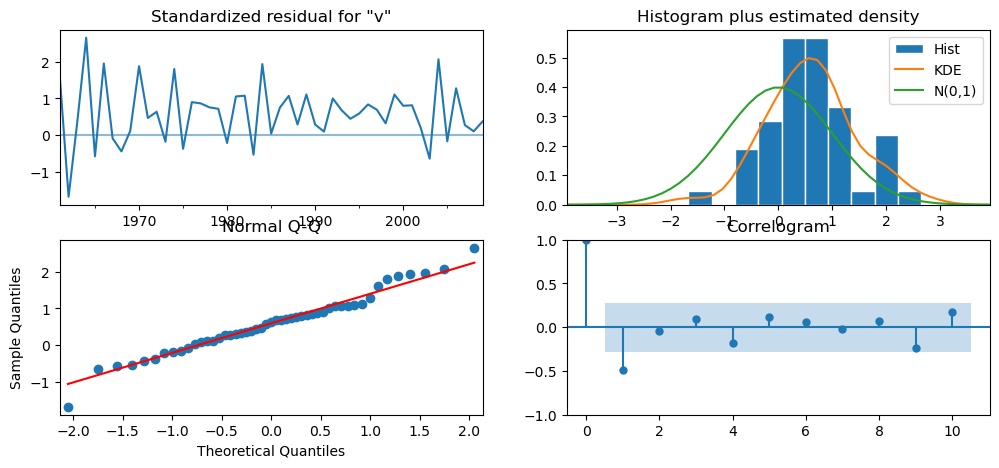

In [43]:
results.plot_diagnostics()
plt.show()

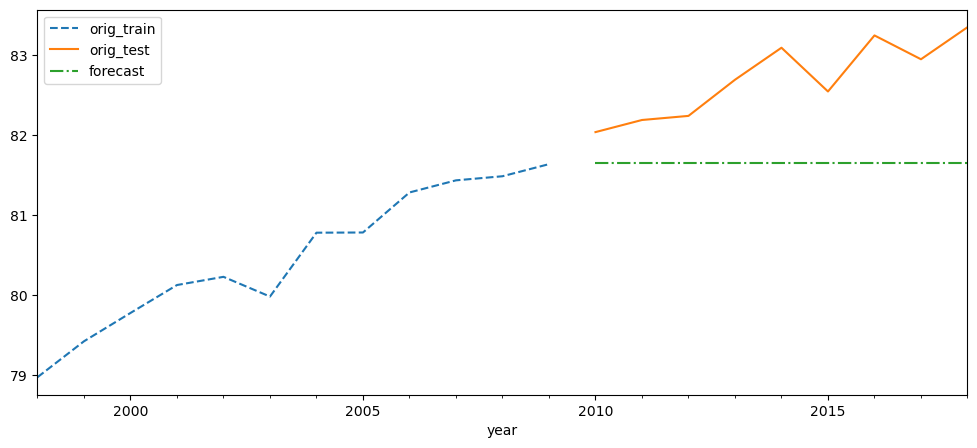

In [44]:
plot_forecast(results, '1998', life_train, life_test)

In [45]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_train.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic,
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
best_m = get_best_model(score, 'AIC')


Best model:8 with lowest AIC score:7.698477131195528


In [46]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Fri, 13 Jan 2023   AIC                              7.698
Time:                        00:54:15   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9475     20.438     -0.095      0.924     -42.005      38.110
ma.L2          0.9994     20.970      0.048      0.962     -40.101      42.100
sigma2         0.0497      1.044      0.048      0.962      -1.996       2.096
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

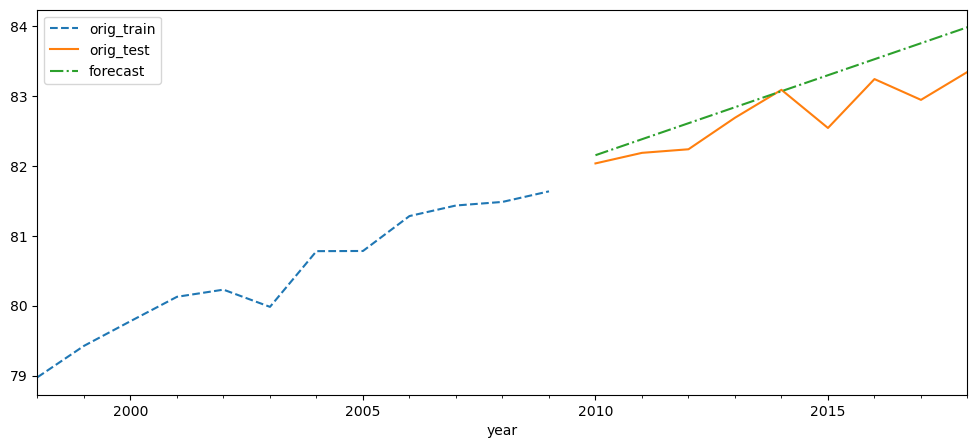

In [47]:
plot_forecast(best_m, '1998', life_train, life_test)


## Forecasting univariate seasonal ARIMA